In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from textwrap import wrap
import random
from functools import reduce

In [2]:
geo_df = gpd.read_file('India_State_Shapefile/India_State_Boundary.shp')

In [3]:
ABM_states=["andaman & nicobar islands", "dadra & nagar haveli and daman & diu", "chhattisgarh", "haryana", "manipur", "assam", "meghalaya", "gujarat", "kerala", "goa", "jammu & kashmir", "nagaland", "mizoram", "tamil nadu", "west bengal", "maharashtra", "andhra pradesh", "tripura", "chandigarh", "punjab", "himachal pradesh", "telangana", "rajasthan", "uttarakhand", "sikkim", "jharkhand", "uttar pradesh", "lakshadweep", "puducherry", "bihar", "madhya pradesh", "arunachal pradesh", "ladakh", "delhi", "odisha", "karnataka"]

In [4]:
dict_states_replace=dict()

dict_states_replace['andaman & nicobar']='andaman & nicobar islands'
dict_states_replace['daman and diu and dadra and nagar haveli']='dadra & nagar haveli and daman & diu'
dict_states_replace['tamilnadu']='tamil nadu'
dict_states_replace['chhattishgarh']='chhattisgarh'
dict_states_replace['telengana']='telangana'
dict_states_replace['jammu and kashmir']='jammu & kashmir'

In [5]:
names_replaced=[]

for name in geo_df['Name']:
    try:
        names_replaced+=[dict_states_replace[name.lower()]]
    except:
        names_replaced+=[name.lower()]
        
geo_df['Name']=names_replaced #Adusted state names so that they are consistent between the geopandas DataFrame and
                                #the naming in the ABM (so that DataFrames can be merged at the state level)

In [6]:
print([i for i in geo_df['Name'].values if i not in ABM_states], #Double check that names are consistent
[i for i in ABM_states if i not in geo_df['Name'].values])

[] []


In [7]:
#Summing population across state, and taking weighted average of growth rate by state (ensuring weighted average is 1.12)

simulation_total_population=70000

death_rate = 0.0082

simulation_steps=4380

state_pop_df=pd.read_csv('district_populations_extrapolated.csv').loc[:,['State','Growth Rate','Population']]
state_pop_df=state_pop_df[state_pop_df['State'].isin(ABM_states)]
state_pop_df['State * Growth Rate']=state_pop_df['Population']*state_pop_df['Growth Rate']
state_pop_df=state_pop_df.groupby('State').sum().reset_index()
state_pop_df['Growth Rate']=state_pop_df['State * Growth Rate']/state_pop_df['Population']
state_pop_df=state_pop_df.drop(columns=['State * Growth Rate'])

state_pop_df['Growth Rate*Population']=state_pop_df['Growth Rate']*state_pop_df['Population']

scale_factor=1.12/(sum(state_pop_df['Growth Rate*Population'])/sum(state_pop_df['Population'])) #want to get growth rate as close to 1.12 as possible.

state_pop_df['Growth Rate*Population']*=scale_factor

state_pop_df['Growth Rate']=state_pop_df['Growth Rate*Population']/state_pop_df['Population']



total_pop=sum(state_pop_df['Population'])

state_pop_df['Population']=[i for i in simulation_total_population*state_pop_df['Population']/total_pop]

for year in range(12):
    
    total_ever_after_year=[]
    pop_after_year=[]
    
    for row in state_pop_df.iterrows():
        pop=row[1]['Population']
        
        total_ever_after_year+=[pop+pop*(row[1]['Growth Rate']+death_rate-1)]
        pop_after_year+=[pop+pop*(row[1]['Growth Rate']-1)]
    
    #After every year, need to readjust all state growth rates again so that yearly growth rate remains at 1.12 with their new population sizes:

    state_pop_df['total_ever_in_simulation']=total_ever_after_year
    
    state_pop_df['Population']=pop_after_year
    
    state_pop_df['Growth Rate*Population']=state_pop_df['Growth Rate']*state_pop_df['Population']

    scale_factor=1.12/(sum(state_pop_df['Growth Rate*Population'])/sum(state_pop_df['Population'])) #want to get growth rate as close to 1.12 as possible.
    
    state_pop_df['Growth Rate*Population']*=scale_factor
    
    state_pop_df['Growth Rate']=state_pop_df['Growth Rate*Population']/state_pop_df['Population']
    
state_pop_df=state_pop_df.loc[:,['State','Population','total_ever_in_simulation']].rename(columns={'State':'Name'})

In [8]:
vaccinations_df=pd.read_csv('vaccination_data_condensed.csv')
wealths_df=pd.read_csv('wealthq_data_condensed.csv')

#state_pop_df
state_district_num=dict()

for state in ABM_states:
    state_district_num[state]=0

for row in wealths_df.iterrows():
    state_district_num[row[1]['state_name']]+=1
    
avg_pop_by_district=dict()
for state in ABM_states:
    avg_pop_by_district[state]=state_pop_df[state_pop_df['Name']==state]['Population'].values[0]/state_district_num[state]
    
populations_districts=[]
for row in wealths_df.iterrows():
    populations_districts+=[avg_pop_by_district[row[1]['state_name']]]
    
wealths_df.iloc[:,2:]=wealths_df.iloc[:,2:].mul(populations_districts,0)
wealths_df.columns=wealths_df.columns.str.replace("prob_", "")

wealths_df.drop(columns=['district_no'],inplace=True)
wealths_df=wealths_df.groupby('state_name').sum().reset_index()

wealths_df = pd.merge(left=wealths_df, right=vaccinations_df, how='left', left_on='state_name', right_on='state_name')

vaccinated_by_wealth_df=pd.DataFrame(data=wealths_df.iloc[:,1:6].values*wealths_df.iloc[:,6:11].values)
vaccinated_by_wealth_df['state_name']=wealths_df['state_name']
wealths_df=wealths_df.iloc[:,0:6]

total_vaccinated_by_state_df=pd.DataFrame(columns=['proportion_vaccinated'],data=vaccinated_by_wealth_df.iloc[:,0:5].sum(axis=1)/wealths_df.iloc[:,1:].sum(axis=1))
total_vaccinated_by_state_df['Name']=wealths_df['state_name']

In [9]:
pneumo_90_abx=pd.read_csv('90%_vaccination_heatmap_data/pneumo-abx-state-nearuniversalcoverage.csv')
pneumo_90_abx=pneumo_90_abx.sum(axis = 0).reset_index().rename(columns={"index":"Name",0:"pneumo_abx"})
pneumo_90_abx_sum=sum(pneumo_90_abx['pneumo_abx'])
pneumo_90_abx['prop_pneumo_abx']=[i/pneumo_90_abx_sum for i in pneumo_90_abx['pneumo_abx']]

pneumo_90_cases=pd.read_csv('90%_vaccination_heatmap_data/pneumo-cases-state-nearuniversalcoverage.csv')
pneumo_90_cases=pneumo_90_cases.sum(axis = 0).reset_index().rename(columns={"index":"Name",0:"pneumo_cases"})
pneumo_90_cases_sum=sum(pneumo_90_cases['pneumo_cases'])
pneumo_90_cases['prop_pneumo_cases']=[i/pneumo_90_cases_sum for i in pneumo_90_cases['pneumo_cases']]

hib_90_abx=pd.read_csv('90%_vaccination_heatmap_data/hib-abx-state-nearuniversalcoverage.csv')
hib_90_abx=hib_90_abx.sum(axis = 0).reset_index().rename(columns={"index":"Name",0:"hib_abx"})
hib_90_abx_sum=sum(hib_90_abx['hib_abx'])
hib_90_abx['prop_hib_abx']=[i/hib_90_abx_sum for i in hib_90_abx['hib_abx']]

hib_90_cases=pd.read_csv('90%_vaccination_heatmap_data/hib-cases-state-nearuniversalcoverage.csv')
hib_90_cases=hib_90_cases.sum(axis = 0).reset_index().rename(columns={"index":"Name",0:"hib_cases"})
hib_90_cases_sum=sum(hib_90_cases['hib_cases'])
hib_90_cases['prop_hib_cases']=[i/hib_90_cases_sum for i in hib_90_cases['hib_cases']]

compiled_df=reduce(lambda x,y: pd.merge(x,y, on='Name', how='outer'), [geo_df, state_pop_df,total_vaccinated_by_state_df, pneumo_90_abx, pneumo_90_cases, hib_90_abx, hib_90_cases])


compiled_df['pneumo_abx/capita/day']=compiled_df['pneumo_abx']/compiled_df['total_ever_in_simulation']/4380

compiled_df['pneumo_cases/capita/day']=compiled_df['pneumo_cases']/compiled_df['total_ever_in_simulation']/4380

compiled_df['hib_abx/capita/day']=compiled_df['hib_abx']/compiled_df['total_ever_in_simulation']/4380

compiled_df['hib_cases/capita/day']=compiled_df['hib_cases']/compiled_df['total_ever_in_simulation']/4380


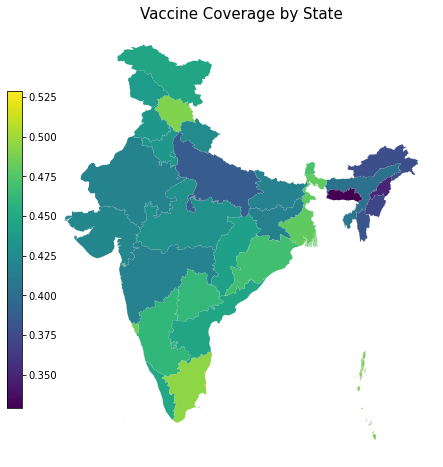

In [10]:
title = "\n".join(wrap("Vaccine Coverage by State", 50))
col = 'proportion_vaccinated'
cmap='viridis'

fig, ax = plt.subplots(1, figsize=(20, 8))

ax.axis('off')
compiled_df.plot(column=col, ax=ax,edgecolor='0.8', linewidth=0.05, cmap=cmap,missing_kwds={'color': 'lightgrey'})

ax.set_title(title, fontdict={'fontsize': '15', 'fontweight': '3'})


# Create colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=compiled_df[col].min(), vmax=compiled_df[col].max()), cmap=cmap)

# Add colorbar to figure
cbaxes = fig.add_axes([0.35, 0.215, 0.01, 0.55])
cbar = fig.colorbar(sm, cax=cbaxes)
plt.savefig('Figures/Vaccination Coverage by State.svg',facecolor='white',bbox_inches='tight')

#### It seems that the burden estimates for the below states may be off

In [67]:
compiled_df[compiled_df['hib_cases/capita/day']>100]

,Name,Type,geometry,Population,total_ever_in_simulation,proportion_vaccinated,pneumo_abx,prop_pneumo_abx,pneumo_cases,prop_pneumo_cases,hib_abx,prop_hib_abx,hib_cases,prop_hib_cases,pneumo_abx/capita/day,pneumo_cases/capita/day,hib_abx/capita/day,hib_cases/capita/day
1,andaman & nicobar islands,Union Territory,"MULTIPOLYGON (((92.90124 12.91071, 92.90157 12...",15.012581,15.157999,0.486311,9.534460e+05,0.032733,4.498039e+07,0.032695,800162.688043,0.032783,5.971648e+07,0.032689,14.360849,677.496802,12.052089,899.452465
9,lakshadweep,Union Territory,"MULTIPOLYGON (((73.08025 8.32651, 73.08029 8.3...",2.174579,2.195920,0.432379,2.417529e+05,0.008300,7.418093e+06,0.005392,241960.892009,0.009913,7.830529e+06,0.004286,25.135133,771.261590,25.156756,814.142750
17,goa,State,"POLYGON ((73.87042 15.78117, 73.87097 15.78029...",61.056373,61.644869,0.484755,8.172135e+05,0.028056,3.780258e+07,0.027478,692752.539566,0.028383,4.979701e+07,0.027259,3.026666,140.007194,2.565707,184.430271
24,sikkim,State,"POLYGON ((88.61635 28.12763, 88.62302 28.12625...",42.718478,43.112971,0.472029,1.032732e+06,0.035455,5.059901e+07,0.036779,845734.954050,0.034651,6.807909e+07,0.037266,5.468969,267.953836,4.478703,360.521938
33,ladakh,Union Territory,"POLYGON ((76.80933 33.24349, 76.79356 33.25175...",26.382601,26.619859,0.446120,1.005384e+06,0.034516,4.966026e+07,0.036097,820331.201019,0.033610,6.702534e+07,0.036689,8.622871,425.921110,7.035733,574.856113


In [69]:
states_only_df=compiled_df[compiled_df['Type'].isin(['State'])]

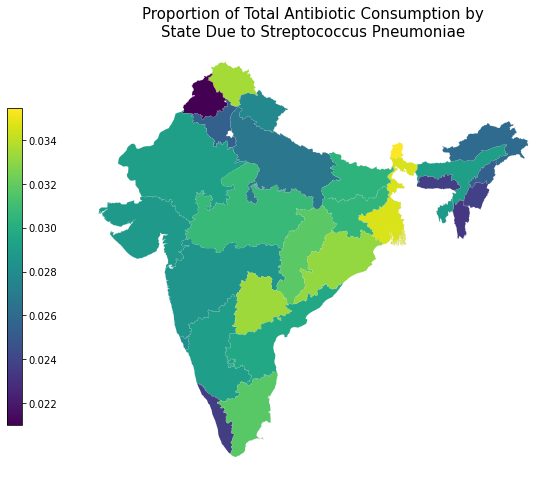

In [70]:
title = "\n".join(wrap("Proportion of Total Antibiotic Consumption by State Due to Streptococcus Pneumoniae", 50))
col = 'prop_pneumo_abx'
cmap='viridis'

fig, ax = plt.subplots(1, figsize=(20, 8))

ax.axis('off')
states_only_df.plot(column=col, ax=ax,edgecolor='0.8', linewidth=0.05, cmap=cmap,missing_kwds={'color': 'lightgrey'})

ax.set_title(title, fontdict={'fontsize': '15', 'fontweight': '3'})


# Create colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=states_only_df[col].min(), vmax=states_only_df[col].max()), cmap=cmap)

# Add colorbar to figure
cbaxes = fig.add_axes([0.3, 0.215, 0.01, 0.55])
cbar = fig.colorbar(sm, cax=cbaxes)
plt.savefig('Proportion of Total Antibiotic Consumption by State Due to Streptococcus Pneumoniae.svg',facecolor='white',bbox_inches='tight')

### All Burden of Disease heatmaps are below at state/union territory level

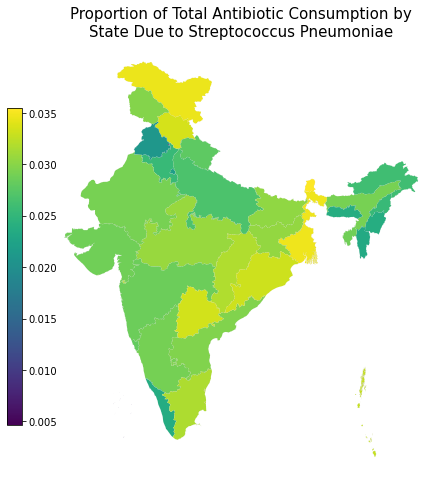

In [61]:
title = "\n".join(wrap("Proportion of Total Antibiotic Consumption by State Due to Streptococcus Pneumoniae", 50))
col = 'prop_pneumo_abx'
cmap='viridis'

fig, ax = plt.subplots(1, figsize=(20, 8))

ax.axis('off')
compiled_df.plot(column=col, ax=ax,edgecolor='0.8', linewidth=0.05, cmap=cmap,missing_kwds={'color': 'lightgrey'})

ax.set_title(title, fontdict={'fontsize': '15', 'fontweight': '3'})


# Create colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=compiled_df[col].min(), vmax=compiled_df[col].max()), cmap=cmap)

# Add colorbar to figure
cbaxes = fig.add_axes([0.35, 0.215, 0.01, 0.55])
cbar = fig.colorbar(sm, cax=cbaxes)
plt.savefig('Figures/Proportion of Total Antibiotic Consumption by State Due to Streptococcus Pneumoniae.svg',facecolor='white',bbox_inches='tight')

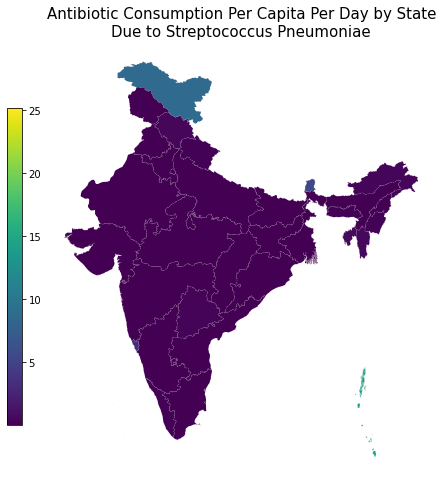

In [13]:
title = "\n".join(wrap("Antibiotic Consumption Per Capita Per Day by State Due to Streptococcus Pneumoniae", 50))
col = 'pneumo_abx/capita/day'
cmap='viridis'

fig, ax = plt.subplots(1, figsize=(20, 8))

ax.axis('off')
compiled_df.plot(column=col, ax=ax,edgecolor='0.8', linewidth=0.05, cmap=cmap,missing_kwds={'color': 'lightgrey'})

ax.set_title(title, fontdict={'fontsize': '15', 'fontweight': '3'})


# Create colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=compiled_df[col].min(), vmax=compiled_df[col].max()), cmap=cmap)

# Add colorbar to figure
cbaxes = fig.add_axes([0.35, 0.215, 0.01, 0.55])
cbar = fig.colorbar(sm, cax=cbaxes)
plt.savefig('Figures/Antibiotic Consumption Per Capita Per Day by State Due to Streptococcus Pneumoniae.svg',facecolor='white',bbox_inches='tight')

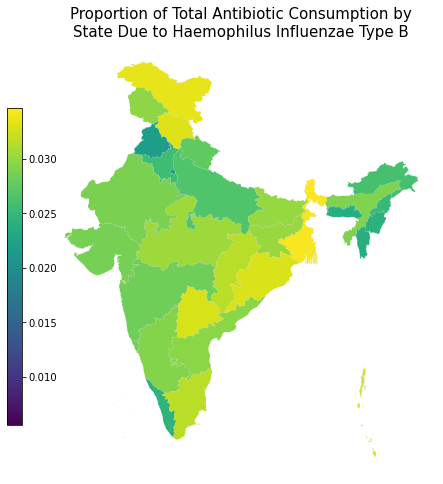

In [14]:
title = "\n".join(wrap("Proportion of Total Antibiotic Consumption by State Due to Haemophilus Influenzae Type B", 50))
col = 'prop_hib_abx'
cmap='viridis'

fig, ax = plt.subplots(1, figsize=(20, 8))

ax.axis('off')
compiled_df.plot(column=col, ax=ax,edgecolor='0.8', linewidth=0.05, cmap=cmap,missing_kwds={'color': 'lightgrey'})

ax.set_title(title, fontdict={'fontsize': '15', 'fontweight': '3'})


# Create colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=compiled_df[col].min(), vmax=compiled_df[col].max()), cmap=cmap)

# Add colorbar to figure
cbaxes = fig.add_axes([0.35, 0.215, 0.01, 0.55])
cbar = fig.colorbar(sm, cax=cbaxes)
plt.savefig('Figures/Proportion of Total Antibiotic Consumption by State Due to Haemophilus Influenzae Type B.svg',facecolor='white',bbox_inches='tight')

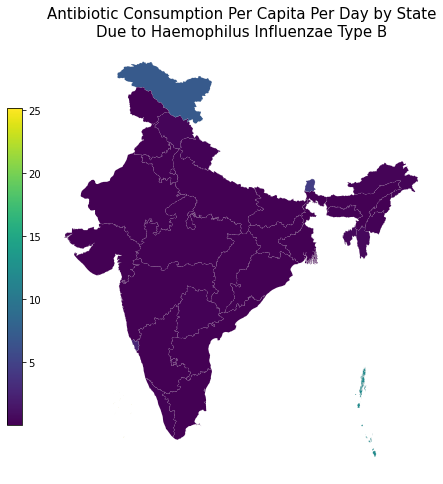

In [15]:
title = "\n".join(wrap("Antibiotic Consumption Per Capita Per Day by State Due to Haemophilus Influenzae Type B", 50))
col = 'hib_abx/capita/day'
cmap='viridis'

fig, ax = plt.subplots(1, figsize=(20, 8))

ax.axis('off')
compiled_df.plot(column=col, ax=ax,edgecolor='0.8', linewidth=0.05, cmap=cmap,missing_kwds={'color': 'lightgrey'})

ax.set_title(title, fontdict={'fontsize': '15', 'fontweight': '3'})


# Create colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=compiled_df[col].min(), vmax=compiled_df[col].max()), cmap=cmap)

# Add colorbar to figure
cbaxes = fig.add_axes([0.35, 0.215, 0.01, 0.55])
cbar = fig.colorbar(sm, cax=cbaxes)
plt.savefig('Figures/Antibiotic Consumption Per Capita Per Day by State Due to Haemophilus Influenzae Type B.svg',facecolor='white',bbox_inches='tight')

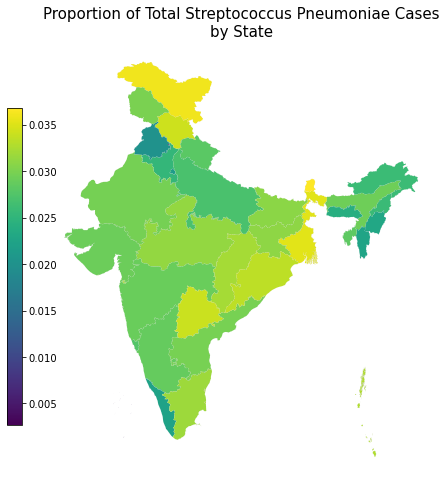

In [16]:
title = "\n".join(wrap("Proportion of Total Streptococcus Pneumoniae Cases by State", 50))
col = 'prop_pneumo_cases'
cmap='viridis'

fig, ax = plt.subplots(1, figsize=(20, 8))

ax.axis('off')
compiled_df.plot(column=col, ax=ax,edgecolor='0.8', linewidth=0.05, cmap=cmap,missing_kwds={'color': 'lightgrey'})

ax.set_title(title, fontdict={'fontsize': '15', 'fontweight': '3'})


# Create colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=compiled_df[col].min(), vmax=compiled_df[col].max()), cmap=cmap)

# Add colorbar to figure
cbaxes = fig.add_axes([0.35, 0.215, 0.01, 0.55])
cbar = fig.colorbar(sm, cax=cbaxes)
plt.savefig('Figures/Proportion of Total Streptococcus Pneumoniae Cases by State.svg',facecolor='white',bbox_inches='tight')

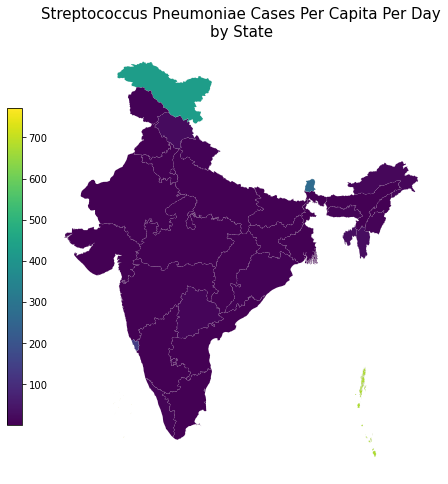

In [17]:
title = "\n".join(wrap("Streptococcus Pneumoniae Cases Per Capita Per Day by State", 50))
col = 'pneumo_cases/capita/day'
cmap='viridis'

fig, ax = plt.subplots(1, figsize=(20, 8))

ax.axis('off')
compiled_df.plot(column=col, ax=ax,edgecolor='0.8', linewidth=0.05, cmap=cmap,missing_kwds={'color': 'lightgrey'})

ax.set_title(title, fontdict={'fontsize': '15', 'fontweight': '3'})


# Create colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=compiled_df[col].min(), vmax=compiled_df[col].max()), cmap=cmap)

# Add colorbar to figure
cbaxes = fig.add_axes([0.35, 0.215, 0.01, 0.55])
cbar = fig.colorbar(sm, cax=cbaxes)
plt.savefig('Figures/Streptococcus Pneumoniae Cases Per Capita Per Day by State.svg',facecolor='white',bbox_inches='tight')

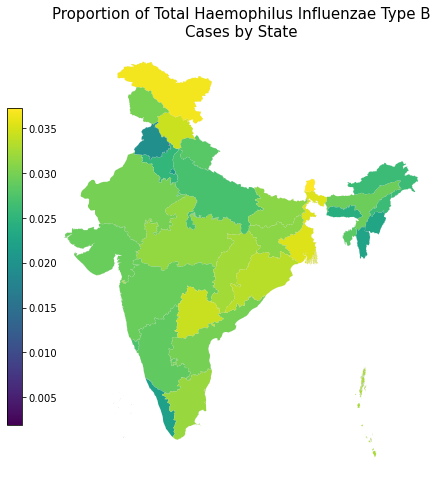

In [18]:
title = "\n".join(wrap("Proportion of Total Haemophilus Influenzae Type B Cases by State", 50))
col = 'prop_hib_cases'
cmap='viridis'

fig, ax = plt.subplots(1, figsize=(20, 8))

ax.axis('off')
compiled_df.plot(column=col, ax=ax,edgecolor='0.8', linewidth=0.05, cmap=cmap,missing_kwds={'color': 'lightgrey'})

ax.set_title(title, fontdict={'fontsize': '15', 'fontweight': '3'})


# Create colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=compiled_df[col].min(), vmax=compiled_df[col].max()), cmap=cmap)

# Add colorbar to figure
cbaxes = fig.add_axes([0.35, 0.215, 0.01, 0.55])
cbar = fig.colorbar(sm, cax=cbaxes)
plt.savefig('Figures/Proportion of Total Haemophilus Influenzae Type B Cases by State.svg',facecolor='white',bbox_inches='tight')

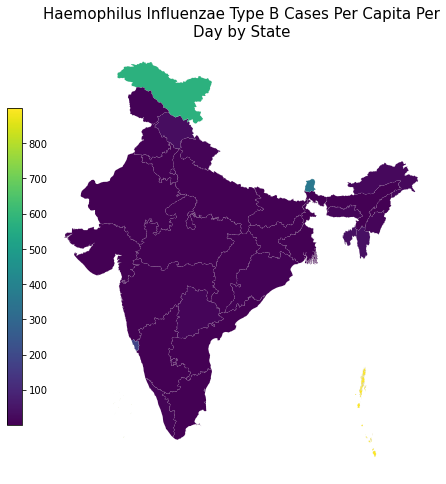

In [19]:
title = "\n".join(wrap("Haemophilus Influenzae Type B Cases Per Capita Per Day by State", 50))
col = 'hib_cases/capita/day'
cmap='viridis'

fig, ax = plt.subplots(1, figsize=(20, 8))

ax.axis('off')
compiled_df.plot(column=col, ax=ax,edgecolor='0.8', linewidth=0.05, cmap=cmap,missing_kwds={'color': 'lightgrey'})

ax.set_title(title, fontdict={'fontsize': '15', 'fontweight': '3'})


# Create colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=compiled_df[col].min(), vmax=compiled_df[col].max()), cmap=cmap)

# Add colorbar to figure
cbaxes = fig.add_axes([0.35, 0.215, 0.01, 0.55])
cbar = fig.colorbar(sm, cax=cbaxes)
plt.savefig('Figures/Haemophilus Influenzae Type B Cases Per Capita Per Day by State.svg',facecolor='white',bbox_inches='tight')